# Interpretable Machine learning
The purpose of this notebook is to take a deep dive into methods for explaining black box models. You see a fair amount of machine learning models implemented online, but little attention is given to the explainability of such models to the users and stakeholders. In industry, more attention needs to be given to the output as users often want to know the reason for a specific prediction. For example, if you were to predict my salary based on features such as job title, work experience, location, etc. then I would like to know how they contributed to the final result. Is work experience more important than the job I apply for? Do you see the same relationship if you were make the prediction for someone else? In other words, which features are important in general and which are important specific to my prediction? 
  
Several methods will be discussed in detail, but a focus will be on Partial Dependency Plots and SHAP values as those are commonly used (relatively) simple to implement in businesses.   

## <a name="table">Table of Contents</a> 

1. [Functions](#functions)  
<br>
2. [Preprocess Data](#preprocess)  
<br>
3. [EDA](#eda)  
<br>
4. [Modeling](#Modeling)  
<br>
5. [Partial Dependency Plots](#dpd)  
<br>
6. [SHAP](#shap)  

## <a name="functions">1. Functions</a> 
[Back to Table of Contents](#table)

In [1]:
import pandas as pd
import numpy as np

import shap
from pdpbox import pdp, get_dataset, info_plots

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def load_and_preprocess_data(path):
    # Load in data
    column_names = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_num', 
                    'Marital_status', 'Occupation', 'Relationship', 'Race', 'Gender', 
                    'Capital_gain', 'Capital_loss', 'Hours/Week', 'Native_country', 
                    'Income_bracket']
    raw_df = pd.read_csv(path, header=None, names=column_names)

    # Get one-hot encoding of non-float/int columns
    one_hot_encoded_columns = pd.get_dummies(raw_df[column_names[:-1]])
    df = raw_df.drop(column_names[:-1],axis = 1)
    df = df.join(one_hot_encoded_columns)

    # Label income bracket and remove fnlwgt column
    df.Income_bracket = df.Income_bracket.map({' <=50K':0, ' >50K': 1})
    df = df.drop('fnlwgt', axis=1)
    
    return raw_df, df

## <a name="preprocess">2. Preprocess Data</a> 
[Back to Table of Contents](#table)

I do some data preprocessing to make sure that it is all in the right format for making the predictions. 

https://www.kaggle.com/johnolafenwa/us-census-data  
  
https://christophm.github.io/interpretable-ml-book/  

https://github.com/slundberg/shap/issues/397

In [2]:
raw_df, df = load_and_preprocess_data("data.csv")

## <a name="eda">3. EDA</a> 
[Back to Table of Contents](#table)

**Missing Values**

In [3]:
print("{} missing values in the data.".format(sum(raw_df.isnull().sum())))

0 missing values in the data.


**Categorical Values**  
Note that there are many categorical variables with each many categories.   
I typically like to use one-hot encoding to make sure the data can be read correctly without assuming some sort of distance between categories.   Fortunately, this is a small dataset which allows for the creation of many features.  
If the data were bigger than I would cluster/chunk some categorical values together as those that happen infrequently are likely not too carry much predictive power. 

In [4]:
raw_df.head()

Age          Workclass  fnlwgt   Education  Education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        Marital_status          Occupation    Relationship    Race   Gender  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital_gain  Capital_loss  Hours/Week  Native_country Income_bracket  
0          2174             0          40   United-States          <=50K  
1             0             0          13   United-States          <=50K  
2             0             0          40   United-States          <=50K  
3             0             0          40   United-States          <=50K  
4             0             0          40            Cuba          <=50K

In [5]:
for column in ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Gender', 'Native_country']:
    print("{} unique categories in {}".format(len(raw_df[column].unique()), column))
print("\n{} additional columns are created".format(len(df.columns)-len(raw_df.columns)))

9 unique categories in Workclass
16 unique categories in Education
7 unique categories in Marital_status
15 unique categories in Occupation
6 unique categories in Relationship
5 unique categories in Race
2 unique categories in Gender
42 unique categories in Native_country

93 additional columns are created


In [6]:
df.head()

Income_bracket  Age  Education_num  Capital_gain  Capital_loss  Hours/Week  \
0               0   39             13          2174             0          40   
1               0   50             13             0             0          13   
2               0   38              9             0             0          40   
3               0   53              7             0             0          40   
4               0   28             13             0             0          40   

   Workclass_ ?  Workclass_ Federal-gov  Workclass_ Local-gov  \
0             0                       0                     0   
1             0                       0                     0   
2             0                       0                     0   
3             0                       0                     0   
4             0                       0                     0   

   Workclass_ Never-worked  ...  Native_country_ Portugal  \
0                        0  ...                         0   
1                        0  ...                         0   
2                        0  ...                         0   
3                        0  ...                         0   
4                        0  ...                         0   

   Native_country_ Puerto-Rico  Native_country_ Scotland  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   Native_country_ South  Native_country_ Taiwan  Native_country_ Thailand  \
0                      0                       0                         0   
1                      0                       0                         0   
2                      0                       0                         0   
3                      0                       0                         0   
4                      0                       0                         0   

   Native_country_ Trinadad&Tobago  Native_country_ United-States  \
0                                0                              1   
1                                0                              1   
2                                0                              1   
3                                0                              1   
4                                0                              0   

   Native_country_ Vietnam  Native_country_ Yugoslavia  
0                        0                           0  
1                        0                           0  
2                        0                           0  
3                        0                           0  
4                        0                           0  

[5 rows x 108 columns]

**Target Variable**

In [7]:
raw_df.Income_bracket.value_counts()

 <=50K    24720
 >50K      7841
Name: Income_bracket, dtype: int64

There is some inbalance with respect to the target variable. Thus, we need to be careful interpreting a simple accuracy measure as it does not take the inbalance into account. Instead, we can use F1-score or even balanced accuracy (macro-average recall). 

## <a name="Modeling">4. Modeling</a> 
[Back to Table of Contents](#table)

In [9]:
# The join moved the target column (Income_bracket) to the beginning
X = df[df.columns[1:]]
y = df[df.columns[0]]

# Train model
clf = LGBMClassifier(random_state=0, n_estimators=100)
fitted_clf = clf.fit(X, y)

**Accuracy**    

In [10]:
scores = cross_val_score(clf, X, y, cv=10); np.mean(scores)

0.8733762434944504

**F1-score**    
<img src = https://wikimedia.org/api/rest_v1/media/math/render/svg/057ffc6b4fa80dc1c0e1f2f1f6b598c38cdd7c23>

In [18]:
scores = cross_val_score(clf, X, y, cv=10, scoring="f1"); np.mean(scores)

0.7144316746290637

**Balanced Accuracy**  
This basically balances the class weights to have equal impact when calculating the accuracy.   
You can see it as the average of recall obtained on each class. 

In [ ]:
scores = cross_val_score(clf, X, y, cv=10, scoring="balanced_accuracy"); np.mean(scores)

You can clearly see the differences between scoring measures.  
It is important to understand to spend sufficient time on validating the performance of your model.  
You do not want to be surprised by poor results after you put the model into production (API, Flask application, Docker, etc.)

## <a name="dpd">5. Dependency Plot</a> 
[Back to Table of Contents](#table)

Partial Dependency Plots (DPD) show the effect a feature has on the outcome of a predictive based model.   
It marginalizes the model output over the distribution of features in order to extract the importance of the feature of interest. 
This importance calculation is based on an important assumption, namely that the feature of interest is not correlated with all other features (except for the target). The reason for this is that it will show data points that are likely to be impossible. For example, weight and height are correlated but the PDP might show the effect of a large weight and very small height on the target while that combination is highly unlikely. This can be partially resolved by showing a rug at the bottom of your PDP. 

**Partial Dependency Plot Assumptions:**
* The assumption of independence is the biggest issue with PD plots. It is assumed that the feature(s) for which the partial dependence is computed are not correlated with other features.
* When the features are correlated, we create new data points in areas of the feature distribution where the actual probability is very low (for example it is unlikely that someone is 2 meters tall but weighs less than 50 kg).

https://christophm.github.io/interpretable-ml-book/pdp.html

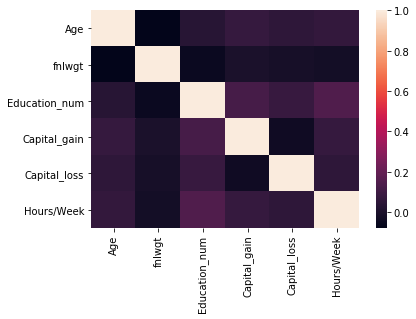

In [15]:
# calculate the correlation matrix
corr = raw_df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [16]:
pdp_embark = pdp.pdp_isolate(
    model=clf, dataset=df[df.columns[1:]], model_features=df.columns[1:], 
    feature=[i for i in df.columns if 'Relationship' in i]
)

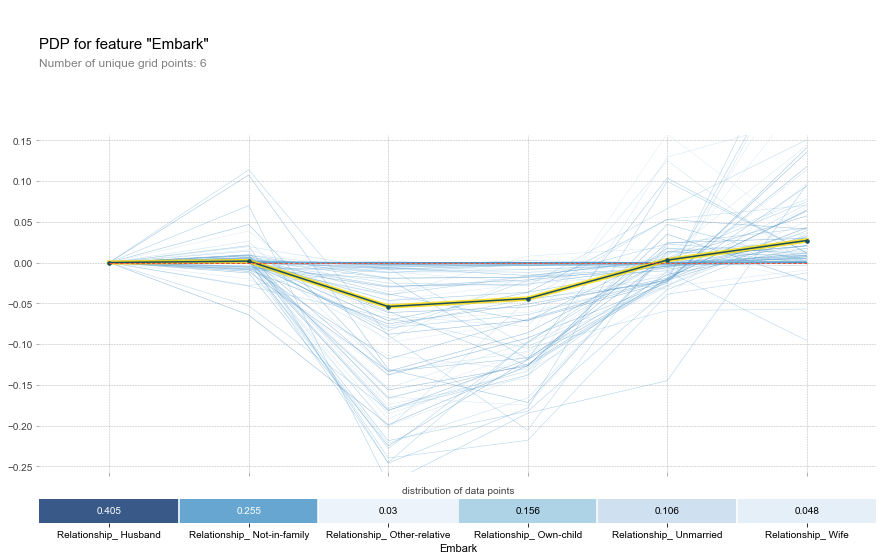

In [17]:
fig, axes = pdp.pdp_plot(pdp_embark, 'Embark', center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True,
                        plot_params = {'xticks_rotation': 111120})

In [18]:
pdp_fare = pdp.pdp_isolate(
    model=clf, dataset=df[df.columns[1:]], model_features=df.columns[1:], feature='Age'
)

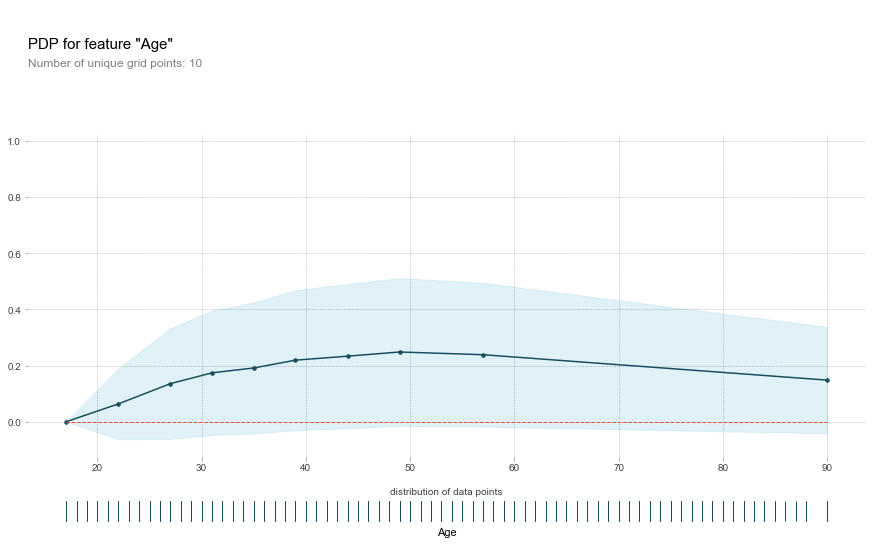

In [19]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Age', plot_pts_dist=True)

In [20]:
inter1 = pdp.pdp_interact(
    model=clf, dataset=df[df.columns[1:]], model_features=df.columns[1:], features=['Age', 'Hours/Week']
)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

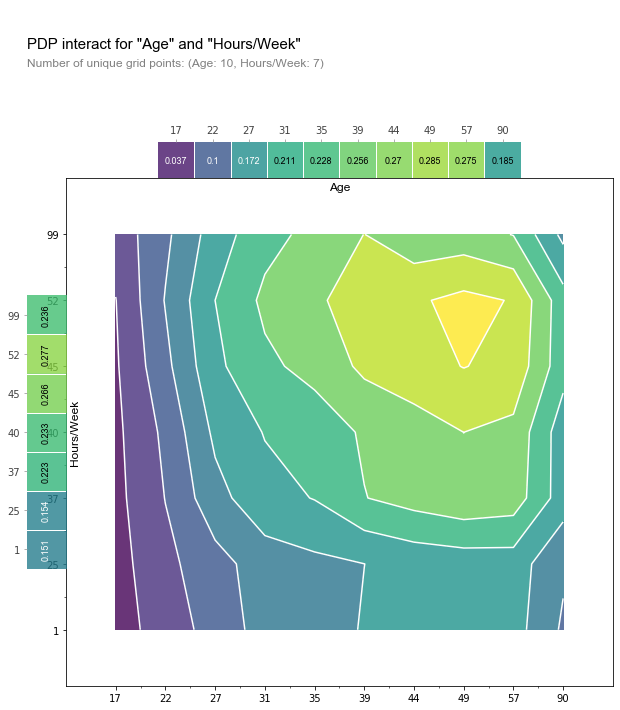

In [21]:
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=inter1, feature_names=['Age', 'Hours/Week'], plot_type='contour', x_quantile=True, plot_pdp=True
)

## <a name="shap">6. SHAP</a> 
[Back to Table of Contents](#table)

In [11]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)

# Calculate Shap values
shap_values = explainer.shap_values(X)

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

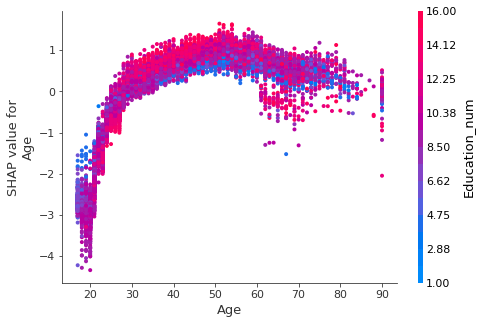

In [13]:
shap.dependence_plot("Age", shap_values, X)

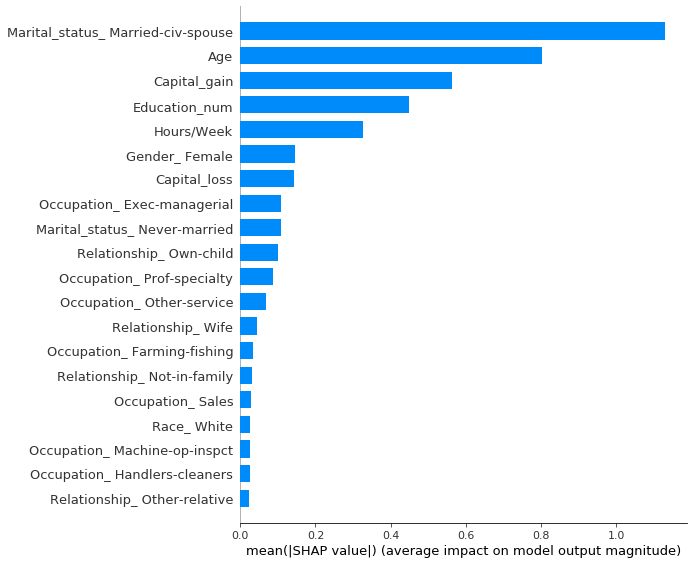

In [14]:
shap.summary_plot(shap_values, X, plot_type="bar")